In [30]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

In [31]:
df=pd.read_csv('/content/AEP_hourly.csv')
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [32]:
#Let's use datetime(2012-10-01 12:00:00,...) as index instead of numbers(0,1,...)
#This will be helpful for further data analysis as we are dealing with time series data
df = pd.read_csv('/content/AEP_hourly.csv', index_col='Datetime', parse_dates=['Datetime'])
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [33]:
#checking missing data
df.isna().sum()

AEP_MW    0
dtype: int64

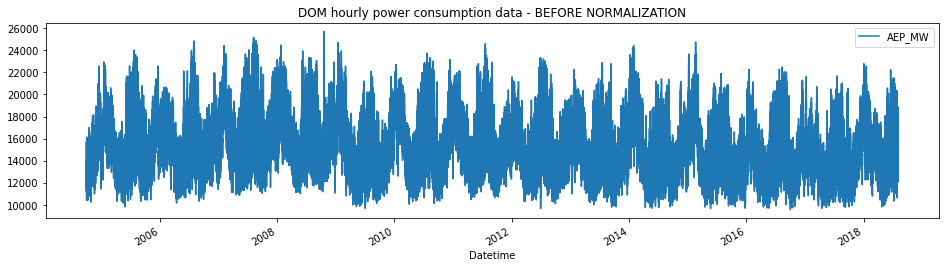

In [34]:
df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

Normalize data
Before proceeding with further data analysis we must ensure that the data is normalized.
For this we will be using sklearn MinMaxScaler

In [35]:
from sklearn.preprocessing import MinMaxScaler
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['AEP_MW']=scaler.fit_transform(df['AEP_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(121273, 1)

In [36]:
df_norm = normalize_data(df)
df_norm.shape

(121273, 1)

Visualize data after normalization
After normalization the range of power consumption values changes which we can observe on the y-axis of the graph. In the earlier graph that was displayed it was in the range 0 - 22500
Now after normalization we can observe that the data range on y-axis is 0.0 - 1.0

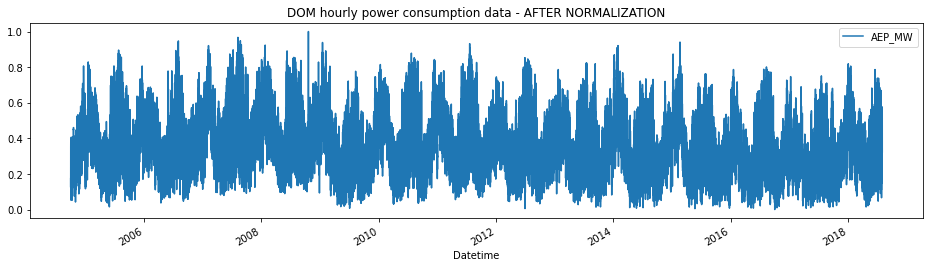

In [37]:
df_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [38]:
df_norm.shape

(121273, 1)

Prepare data for training the RNN models

In [39]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    return [X_train, y_train, X_test, y_test]

In [40]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (11253, 20, 1)
y_test.shape =  (11253,)


Build a SIMPLE RNN model

In [41]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 20, 40)            1680      
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_11 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [42]:
rnn_model.compile(optimizer="adam",loss="mse")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 12s 80ms/step - loss: 0.2159
Epoch 2/10
110/110 [==============================] - 9s 79ms/step - loss: 0.0336
Epoch 3/10
110/110 [==============================] - 9s 78ms/step - loss: 0.0170
Epoch 4/10
110/110 [==============================] - 9s 77ms/step - loss: 0.0112
Epoch 5/10
110/110 [==============================] - 9s 78ms/step - loss: 0.0084
Epoch 6/10
110/110 [==============================] - 9s 78ms/step - loss: 0.0067
Epoch 7/10
110/110 [==============================] - 9s 79ms/step - loss: 0.0055
Epoch 8/10
110/110 [==============================] - 9s 78ms/step - loss: 0.0047
Epoch 9/10
110/110 [==============================] - 9s 79ms/step - loss: 0.0042
Epoch 10/10
110/110 [==============================] - 9s 78ms/step - loss: 0.0038


Let's check r2 score for the values predicted by the above trained SIMPLE RNN model

In [43]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.9627035992082487


Let's compare the actual values vs predicted values by plotting a graph
We see that the predcited values are close to the actual values meaning the RNN model is performing well in predicting the sequence.

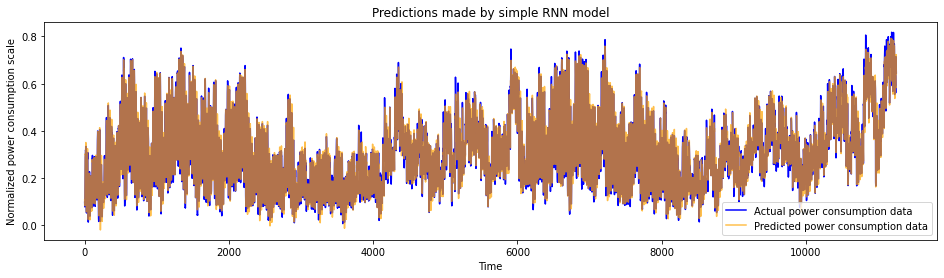

In [44]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

Build an LSTM model

In [45]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 20, 40)            6720      
_________________________________________________________________
dropout_12 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_13 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_14 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [46]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 29s 222ms/step - loss: 0.0354
Epoch 2/10
110/110 [==============================] - 24s 217ms/step - loss: 0.0155
Epoch 3/10
110/110 [==============================] - 24s 221ms/step - loss: 0.0073
Epoch 4/10
110/110 [==============================] - 24s 222ms/step - loss: 0.0045
Epoch 5/10
110/110 [==============================] - 24s 221ms/step - loss: 0.0032
Epoch 6/10
110/110 [==============================] - 24s 220ms/step - loss: 0.0026
Epoch 7/10
110/110 [==============================] - 24s 219ms/step - loss: 0.0023
Epoch 8/10
110/110 [==============================] - 24s 220ms/step - loss: 0.0021
Epoch 9/10
110/110 [==============================] - 24s 221ms/step - loss: 0.0020
Epoch 10/10
110/110 [==============================] - 24s 218ms/step - loss: 0.0019


Let's check r2 score for the values predicted by the above trained LSTM model

In [47]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.9675790662902304


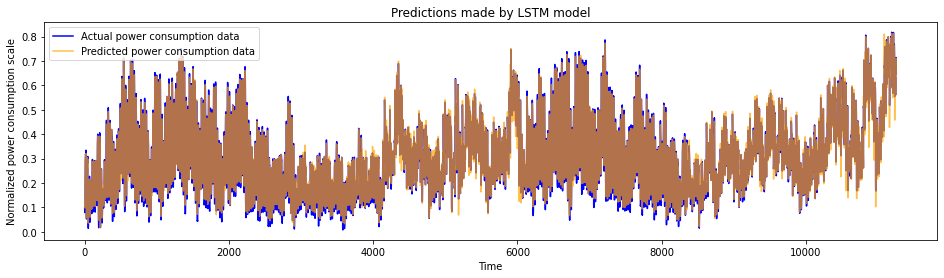

In [48]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

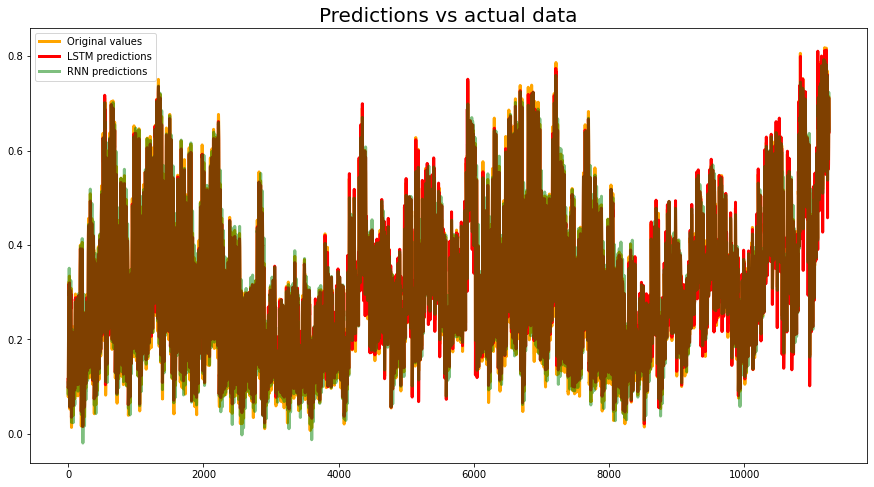

In [49]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()